# Inference Palm detection model on Hailo device

### Model name definitions for this notebook

In [1]:
model_name = "palm_detection_full"

### General imports used throughout the inference

In [2]:
from typing import Any, Dict, List, Optional, Tuple, Union, Callable, Iterator, TypeVar
from pathlib import Path
from hailo_platform import (
    HEF,
    ConfigureParams,
    FormatOrder,
    FormatType,
    HailoSchedulingAlgorithm,
    HailoStreamInterface,
    InferVStreams,
    InputVStreamParams,
    OutputVStreamParams,
    VDevice,
)
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

### Generic Inference Class

In [3]:
# Configuration constants
TIMEOUT_MS = 10000  # Timeout for asynchronous operations in milliseconds


T = TypeVar('T')

class InferPipeline:
    """
    Class to manage asynchronous and blocking inference pipelines for processing input data
    using deep learning models stored in Hailo Executable Format (HEF).

    This class provides a flexible interface for loading and running inference on various
    models with support for both synchronous and asynchronous execution modes. It handles
    input and output tensor formatting, buffer management, and execution scheduling.

    Attributes:
        out_results (dict): Dictionary to store output results from asynchronous inference.
        layer_name_u8 (list): List of layer names that produce uint8 format tensors as outputs.
        layer_name_u16 (list): List of layer names that produce uint16 format tensors as outputs.
        configured_infer_model: The configured inference model ready for execution.
        bindings: Handles input/output data bindings for the model.
        job: Represents the current asynchronous inference job.
        is_async (bool): Whether to use asynchronous inference mode.
        is_callback (bool): Whether to use callbacks for asynchronous inference.
        is_nms (bool): Whether NMS (Non-Maximum Suppression) is enabled.
        vdevice: Virtual device instance for hardware acceleration.
    """

    def __init__(
        self,
        net_path: str,
        batch_size: int,
        is_async: bool,
        is_callback: bool,
        is_nms: bool,
        layer_name_u8: List[str],
        layer_name_u16: List[str],
    ) -> None:
        """
        Initialize the InferPipeline class with model configuration and execution parameters.

        Args:
            net_path (str): Path to the Hailo Executable Format (HEF) model file.
            batch_size (int): Number of inputs to process in a single batch.
            is_async (bool): Whether to use asynchronous inference mode.
            is_callback (bool): Whether to use callbacks for asynchronous inference results.
            is_nms (bool): Whether NMS (Non-Maximum Suppression) is enabled in the model.
            layer_name_u8 (list): Names of layers outputting uint8 formatted tensors.
            layer_name_u16 (list): Names of layers outputting uint16 formatted tensors.
        """
        self.out_results = {}  # Store inference results
        # Layers that output uint8 format tensors
        self.layer_name_u8 = layer_name_u8
        # Layers that output uint16 format tensors
        self.layer_name_u16 = layer_name_u16

        self.configured_infer_model = None
        self.bindings = None
        self.job = None
        self.is_async = is_async
        self.is_callback = is_callback
        self.is_nms = is_nms

        # Create VDevice and set the parameters for scheduling algorithm
        params = VDevice.create_params()
        params.scheduling_algorithm = HailoSchedulingAlgorithm.ROUND_ROBIN

        try:
            self.vdevice = VDevice(params)

            if self.is_async:
                # Load the model onto the device
                self.infer_model = self.vdevice.create_infer_model(net_path)

                # Set batch size for inference operations on the loaded model
                self.infer_model.set_batch_size(batch_size)

                for out_name in self.infer_model.output_names:
                    # Default output type is float32
                    if out_name in self.layer_name_u8:
                        self.infer_model.output(out_name).set_format_type(
                            FormatType.UINT8
                        )
                    elif out_name in self.layer_name_u16:
                        self.infer_model.output(out_name).set_format_type(
                            FormatType.UINT16
                        )
                    else:
                        self.infer_model.output(out_name).set_format_type(
                            FormatType.FLOAT32
                        )
            else:
                # Load the HEF model into device and configure it
                self.hef = HEF(net_path)

                # Configure network groups
                configure_params = ConfigureParams.create_from_hef(
                    hef=self.hef, interface=HailoStreamInterface.PCIe
                )
                self.network_group = (
                    self.vdevice.configure(self.hef, configure_params)
                )[0]

                # Create input and output virtual stream parameters for inference
                self.input_vstreams_params = InputVStreamParams.make(
                    self.network_group,
                    format_type=FormatType.UINT8,
                )
                self.output_vstreams_params = OutputVStreamParams.make(
                    self.network_group, format_type=FormatType.FLOAT32
                )

            # Setup the appropriate inference function based on is_async flag
            if self.is_async:
                self.inference = lambda dataset: self.infer_async(dataset)
            else:
                self.inference = lambda dataset: self.infer_pipeline(dataset)

        except Exception as e:
            print(f"Error during inference: {e}")

    def close(self) -> None:
        """
        Clean up resources used by the inference pipeline.

        This method ensures proper cleanup of all allocated resources, including
        the configured inference model and the virtual device. It should be called
        when the pipeline is no longer needed to prevent resource leaks.

        The method performs the following operations:
        1. Resets the configured inference model to free associated resources
        2. Releases the virtual device resources

        This is typically used as part of a teardown process in a try-finally block
        or when an object is no longer needed.
        """
        # Reset the configured inference model to free resources
        if self.configured_infer_model is not None:
            self.configured_infer_model = None

        # Release the vdevice resource
        self.vdevice.release()

    def callback(self, completion_info: Any) -> None:
        """
        Callback function to handle the completion of asynchronous inference.

        This function is invoked when an asynchronous inference operation completes.
        It processes the results, handles any exceptions that occurred during inference,
        and stores the output buffers in the out_results dictionary for later retrieval.

        Args:
            completion_info: An object containing information about the completion status,
                             including exceptions if any occurred during inference, and
                             access to output buffers with inference results.
        """
        if completion_info.exception:
            # Handle exceptions that occurred during inference
            print(f"Inference error: {completion_info.exception}")
        else:
            for out_name in self.bindings._output_names:
                # Store results from each output layer into self.out_results
                if self.is_nms:
                    self.out_results[out_name] = np.array(
                        self.bindings.output(out_name).get_buffer(), dtype=object
                    )
                else:
                    self.out_results[out_name] = self.bindings.output(
                        out_name
                    ).get_buffer()

    def infer_async(self, infer_inputs: List[np.ndarray]) -> None:
        """
        Perform asynchronous inference on input data.

        This method configures and starts an asynchronous inference operation on the provided
        input data. It handles the setup of input and output buffers, configures the model,
        and initiates the asynchronous inference job. Results can be retrieved later using
        the wait_and_get_output method.

        Args:
            infer_inputs (list): List of input data arrays for the model.

        Returns:
            None: The method initiates inference but doesn't wait for results. Call
                  wait_and_get_output() to retrieve the results after completion.
        """
        try:
            self.configured_infer_model = self.infer_model.configure()

            # Create bindings to manage input/output data buffers
            self.bindings = self.configured_infer_model.create_bindings()

            # Set input buffers using the provided infer inputs
            for in_name, infer_input in zip(self.infer_model.input_names, infer_inputs):
                self.bindings.input(in_name).set_buffer(infer_input)

            # Allocate and set output buffers based on expected data format type
            for out_name in self.infer_model.output_names:
                out_buffer = np.array([])
                # Default output type is float32
                if out_name in self.layer_name_u8:
                    out_buffer = np.empty(
                        self.infer_model.output(out_name).shape,
                        dtype=np.uint8,
                    )
                elif out_name in self.layer_name_u16:
                    out_buffer = np.empty(
                        self.infer_model.output(out_name).shape,
                        dtype=np.uint16,
                    )
                else:
                    out_buffer = np.empty(
                        self.infer_model.output(out_name).shape,
                        dtype=np.float32,
                    )

                self.bindings.output(out_name).set_buffer(out_buffer)

            # Set timeout for async inference
            self.configured_infer_model.wait_for_async_ready(timeout_ms=TIMEOUT_MS)

            if self.is_callback:
                # Start inference and use callback function for handling results
                self.job = self.configured_infer_model.run_async(
                    [self.bindings], partial(self.callback)
                )
            else:
                # Start inference without callback
                self.job = self.configured_infer_model.run_async([self.bindings])

        except Exception as e:
            print(f"Error during inference: {e}")

        return None

    def wait_and_get_ouput(self) -> Dict[str, np.ndarray]:
        """
        Wait for an asynchronous inference job to complete and collect the output results.

        This method blocks until either the inference job completes or the specified timeout
        is reached. Once completed, it retrieves the inference results from the output buffers
        and returns them as a dictionary keyed by output layer names.

        Returns:
            dict: A dictionary mapping output layer names to their corresponding inference results.
                 Each result is a numpy array with the shape and type specified during configuration.

        Raises:
            Exception: If an error occurs during waiting or result collection, the exception
                      is caught and printed to the console, and an empty dictionary is returned.
        """
        infer_results = {}

        try:
            # Wait for inference to complete with the specified timeout
            self.job.wait(TIMEOUT_MS)

            # Collect the final results after completion
            for index, out_name in enumerate(self.infer_model.output_names):
                if self.is_callback:
                    # For callback mode, results are already in self.out_results
                    buffer = (
                        np.array(self.out_results[out_name], dtype=object)
                        if self.is_nms
                        else self.out_results[out_name]
                    )
                else:
                    # For no-callback mode, manually collect results after waiting
                    if self.is_nms:
                        buffer = np.array(
                            self.bindings.output(
                                self.infer_model.output_names[index]
                            ).get_buffer(),
                            dtype=object,
                        )
                    else:
                        buffer = self.bindings.output(
                            self.infer_model.output_names[index]
                        ).get_buffer()

                infer_results[out_name] = buffer

        except Exception as e:
            print(f"Error during inference: {e}")

        return infer_results

    def infer_pipeline(self, infer_inputs: List[np.ndarray]) -> Dict[str, np.ndarray]:
        """
        Perform synchronous (blocking) inference on input data using a network group configuration.

        This method executes inference in a blocking manner, waiting for the results before returning.
        It configures virtual streams for inputs and outputs, runs the inference, and collects
        the results immediately.

        Args:
            infer_inputs (list): List of input data arrays for the model.

        Returns:
            dict: A dictionary mapping output layer names to their corresponding inference results.
                 Each result is a numpy array with the shape and type specified during configuration.
        """
        infer_results = {}

        try:
            # Prepare input data by expanding dimensions for each input stream
            input_data = {}
            for i, input_vstream_info in enumerate(self.hef.get_input_vstream_infos()):
                input_data[input_vstream_info.name] = infer_inputs[i][np.newaxis, :]

            # Perform inference on the network group using configured virtual streams
            with InferVStreams(
                self.network_group,
                self.input_vstreams_params,
                self.output_vstreams_params,
            ) as infer_pipeline:
                buffer = infer_pipeline.infer(input_data)
                for i, output_vstream_info in enumerate(
                    self.hef.get_output_vstream_infos()
                ):
                    if self.is_nms:
                        infer_results[output_vstream_info.name] = np.array(
                            buffer[output_vstream_info.name][0], dtype=object
                        )
                    else:
                        # Remove batch dimension for regular outputs
                        infer_results[output_vstream_info.name] = buffer[
                            output_vstream_info.name
                        ].squeeze()

        except Exception as e:
            print(f"Error during inference: {e}")

        return infer_results

### Function to Inference with hef and specific image

In [4]:
def format_tensor_info(name, format, order, shape):
    """Returns a string representation of a tensor with specified format and order.

    This function generates a formatted string that describes the structure and
    attributes of a tensor. It is particularly useful for logging or debugging purposes,
    where understanding tensor dimensions and types may be crucial for diagnosing issues
    in data processing pipelines or machine learning workflows.

    The function takes into account different possible shapes of the tensor, supporting:
    - 1D tensors represented simply by their size.
    - 2D tensors described by height and width.
    - 3D tensors extended with channel information.

    Parameters:
        name (str): The identifier or name of the tensor.
        format: An object representing the data format. It is assumed that this can be
                converted to a string, where only the last segment after a dot is used.
        order: An object representing the storage order in memory. Similar to `format`, it
               should have a string representation with meaningful segments post-dot.
        shape (tuple): A tuple indicating the dimensions of the tensor. Only tuples
                       of length 1, 2, or 3 are supported.

    Returns:
        str: A formatted description string that includes the name, format, order, and
             dimensional details of the tensor.

    Raises:
        ValueError: If `shape` is not a tuple with 1, 2, or 3 elements, which ensures
                    only valid configurations are processed.

    Example Use Cases:
    - For diagnostics, when visualizing model architectures where tensor dimensions must be clear.
    - In logging systems to record tensor metadata at various stages of data processing.

    Notes on Implementation:
    The function employs string manipulations to extract relevant segments from `format` and
    `order`. It uses conditional checks to determine how to format the output based on the size
    of `shape`, which allows for flexible handling of different types of tensors.
    """
    if not isinstance(shape, tuple) or len(shape) not in [1, 2, 3]:
        raise ValueError("tensor must be a tuple of length 1, 2 or 3")

    format = str(format).rsplit(".", 1)[1]
    order = str(order).rsplit(".", 1)[1]

    if len(shape) == 3:
        H, W, C = shape[:3]
        return f"{name} {format}, {order}({H}x{W}x{C})"
    if len(shape) == 2:
        H, W = shape[:2]
        return f"{name} {format}, {order}({H}x{W})"
    else:
        C = shape[0]
        return f"{name} {format}, {order}({C})"


def preprocess_image_from_array(image_array, shape):
    """Resize and pad images to be input for detectors.

    The face and palm detector networks take 256x256 and 128x128 images
    as input. As such, the image is resized to fit these dimensions while maintaining aspect ratio.

    Parameters:
    - image_array: numpy array representing the image.
    - shape: tuple or integer specifying the target size (height, width).

    Returns:
    - img: Resized image as a numpy array.
    - scale: Scale factor between original and target sizes.
    - pad: Pixels of padding applied in the original image.
    """

    # Determine input dimensions
    height, width = image_array.shape[:2]
    target_height, target_width = shape if isinstance(shape, tuple) else (shape, shape)

    # Calculate scale for resizing
    scale0 = width / target_width
    scale1 = height / target_height

    # Resize image using PIL's resize method with LANCZOS for high-quality downsampling
    img_resized = img.resize((target_width, target_height), Image.Resampling.LANCZOS)

    return img_resized, (scale0, scale1), (0, 0)


def preprocess_image_from_array_with_pad(image_array, shape):
    """Resize and pad images to be input for detectors.

    The face and palm detector networks take 256x256 and 128x128 images
    as input. As such, the image is resized and padded to fit these dimensions while maintaining aspect ratio.

    Parameters:
    - image_array: numpy array representing the image.
    - shape: tuple or integer specifying the target size (height, width).

    Returns:
    - img: Resized and padded image as a numpy array.
    - scale: Scale factor between original and target sizes.
    - pad: Pixels of padding applied in the original image.
    """

    # Determine input dimensions
    height, width = image_array.shape[:2]
    target_height, target_width = shape if isinstance(shape, tuple) else (shape, shape)

    # Convert numpy array to PIL Image if necessary
    if isinstance(image_array, np.ndarray):
        img = Image.fromarray(image_array)
    else:
        img = image_array

    size0 = img.size  # (width, height)
    
    if height >= width:  # width <= height
        h1 = int(target_height)
        w1 = int((target_height / height) * width)
        padh = 0
        padw = int((target_width - w1) / 2)
        scale = height / h1
    else:  # height < width
        w1 = int(target_width)
        h1 = int((target_width / width) * height)
        padh = int((target_height - h1) / 2)
        padw = 0
        scale = width / w1

    # Resize image using PIL's resize method with LANCZOS for high-quality downsampling
    img_resized = img.resize((w1, h1), Image.Resampling.LANCZOS)

    # Convert resized image to numpy array for padding
    img_array = np.array(img_resized)

    # Pad the resized image to the target dimensions
    padh1, padh2 = padh, target_height - h1 - padh
    padw1, padw2 = padw, target_width - w1 - padw

    # Pad the image using numpy's pad function
    img_padded = np.pad(
        img_array, ((padh1, padh2), (padw1, padw2), (0, 0)), mode='constant', constant_values=0
    )

    # Calculate padding in original scale
    pad = (int(padh * scale), int(padw * scale))

    return img_padded, (scale, scale), pad


def format_and_print_vstream_info(vstream_infos, is_input=True):
    """
    Formats and prints information about vstream objects.

    This function iterates over a list of vstream objects, formats their
    details such as name, format type, order, and shape, and prints this
    information. It also yields the name, shape, and format type of each
    vstream object.

    Parameters:
    - vstream_infos (list): A list of vstream objects containing attributes like
                            name, format, and shape.
    - is_input (bool): Flag indicating if the vstreams are inputs or outputs.
                       Default is True (inputs).

    Yields:
    - tuple: A tuple containing the name, shape, and format type of each vstream.

    Returns:
    - None
    """

    # Iterate over each vstream object with an index
    for i, vstream in enumerate(vstream_infos):
        # Extract attributes from the vstream object
        name = vstream.name
        fmt_type = vstream.format.type
        order = vstream.format.order
        shape = vstream.shape

        # Format the info string based on whether it's input or output
        info = f"{'Input' if is_input else 'Output'} #{i} {format_tensor_info(name, fmt_type, order, shape)}"

        # Print the formatted information
        print(info)

        # Yield a tuple of name, shape, and format type for further processing
        yield name, shape, fmt_type, order


def inference_with_single_image(hef_name, layer_name_u8, layer_name_u16, frame):
    """
    Perform inference on a single image using the specified HEF model.

    This function loads a model from the given network file path (HEF), prepares an input 
    frame by resizing and padding it to match the required input shape of the model,
    and performs either synchronous or asynchronous inference. The results, along with
    scaling and padding information used during preprocessing, are returned.
    
    Parameters:
    - hef_name (str): Path to the HEF file containing the neural network model.
    - layer_name_u8 (str): Name of the U8 output layer from the model.
    - layer_name_u16 (str): Name of the U16 output layer from the model.
    - frame: The input image in a format compatible with numpy arrays, typically 
      captured as an RGB or grayscale image.

    Returns:
    - tuple: Contains inference outputs, scale factor, and padding information used
             during preprocessing. If no valid outputs are obtained, it returns None.
    
    Raises:
    - ValueError: If the model does not have a single input tensor or if any 
      shapes in the inputs are invalid.
    """
    input_shape = []
    is_nms = False
    
    try:
        # Load the model using the provided network file path
        hef = HEF(hef_name)

        # Retrieve input vstream information from the model
        vstream_inputs = hef.get_input_vstream_infos()

        if not vstream_inputs:
            raise ValueError("No input streams found in the model.")

        print("VStream infos(inputs):")

        # Format and print input information for debugging purposes
        for in_name, in_shape, _, _ in format_and_print_vstream_info(
            vstream_inputs, is_input=True
        ):
            if len(in_shape) < 2:
                raise ValueError(f"Invalid shape for input {in_name}: {in_shape}")
            # Store the first two dimensions of each input shape
            input_shape.append(in_shape[:2])

        # Retrieve output vstream information from the model
        vstream_outputs = hef.get_output_vstream_infos()

        print("VStream infos(outputs):")

        # Categorize layers based on their output format and store their names
        for out_name, _, out_format, out_order in format_and_print_vstream_info(
            vstream_outputs, is_input=False
        ):
            if out_order == FormatOrder.HAILO_NMS_BY_CLASS:
                is_nms = True

        # Check input tensor is only one here
        if len(vstream_inputs) != 1:
            raise ValueError(
                "This note is only supports the model with the single input tensor. Quitting."
            )

        # Initialize the inference pipeline with model and processing parameters
        batch_size = 1
        is_async = False
        is_callback = False
        infer = InferPipeline(
            hef_name, batch_size, is_async, is_callback, is_nms, layer_name_u8, layer_name_u16
        )

        # Preprocess the frame by resizing and padding it according to input shape
        image_array = np.array(frame)
        input_frame, scale, pad = preprocess_image_from_array_with_pad(
            image_array, input_shape[0]
        )
        inference_dataset = [input_frame]  # Prepare dataset for current frame

        try:
            # Perform synchronous inference with the prepared dataset
            outputs = infer.inference(inference_dataset)

        except Exception as e:
            print(f"Error during inference: {e}")

    finally:
        if "infer" in locals():
            infer.close()

    return outputs, input_shape[0], scale, pad

### Palm detection post process

In [5]:
"""
Based on code from :
https://github.com/AlbertaBeef/blaze_app_python/blob/main/blaze_common/blazebase.py
"""

def calculate_scale(min_scale, max_scale, stride_index, num_strides):
    if num_strides == 1:
        return (max_scale + min_scale) * 0.5
    else:
        return min_scale + (max_scale - min_scale) * stride_index / (num_strides - 1.0)


def generate_anchors(options):
    strides_size = len(options["strides"])
    assert options["num_layers"] == strides_size

    anchors = []
    layer_id = 0
    while layer_id < strides_size:
        anchor_height = []
        anchor_width = []
        aspect_ratios = []
        scales = []

        # For same strides, we merge the anchors in the same order.
        last_same_stride_layer = layer_id
        while (last_same_stride_layer < strides_size) and (
            options["strides"][last_same_stride_layer] == options["strides"][layer_id]
        ):
            scale = calculate_scale(
                options["min_scale"],
                options["max_scale"],
                last_same_stride_layer,
                strides_size,
            )

            if last_same_stride_layer == 0 and options["reduce_boxes_in_lowest_layer"]:
                # For first layer, it can be specified to use predefined anchors.
                aspect_ratios.append(1.0)
                aspect_ratios.append(2.0)
                aspect_ratios.append(0.5)
                scales.append(0.1)
                scales.append(scale)
                scales.append(scale)
            else:
                for aspect_ratio in options["aspect_ratios"]:
                    aspect_ratios.append(aspect_ratio)
                    scales.append(scale)

                if options["interpolated_scale_aspect_ratio"] > 0.0:
                    scale_next = (
                        1.0
                        if last_same_stride_layer == strides_size - 1
                        else calculate_scale(
                            options["min_scale"],
                            options["max_scale"],
                            last_same_stride_layer + 1,
                            strides_size,
                        )
                    )
                    scales.append(np.sqrt(scale * scale_next))
                    aspect_ratios.append(options["interpolated_scale_aspect_ratio"])

            last_same_stride_layer += 1

        for i in range(len(aspect_ratios)):
            ratio_sqrts = np.sqrt(aspect_ratios[i])
            anchor_height.append(scales[i] / ratio_sqrts)
            anchor_width.append(scales[i] * ratio_sqrts)

        stride = options["strides"][layer_id]
        feature_map_height = int(np.ceil(options["input_size_height"] / stride))
        feature_map_width = int(np.ceil(options["input_size_width"] / stride))

        for y in range(feature_map_height):
            for x in range(feature_map_width):
                for anchor_id in range(len(anchor_height)):
                    x_center = (x + options["anchor_offset_x"]) / feature_map_width
                    y_center = (y + options["anchor_offset_y"]) / feature_map_height

                    new_anchor = [x_center, y_center, 0, 0]
                    if options["fixed_anchor_size"]:
                        new_anchor[2] = 1.0
                        new_anchor[3] = 1.0
                    else:
                        new_anchor[2] = anchor_width[anchor_id]
                        new_anchor[3] = anchor_height[anchor_id]
                    anchors.append(new_anchor)

        layer_id = last_same_stride_layer

    anchors = np.asarray(anchors)

    return anchors


def _decode_boxes(raw_boxes, anchors, configs):
    """Converts the predictions into actual coordinates using
    the anchor boxes. Processes the entire batch at once.
    """
    boxes = np.zeros(raw_boxes.shape)

    x_center = raw_boxes[..., 0] / configs["x_scale"] * anchors[:, 2] + anchors[:, 0]
    y_center = raw_boxes[..., 1] / configs["y_scale"] * anchors[:, 3] + anchors[:, 1]

    w = raw_boxes[..., 2] / configs["w_scale"] * anchors[:, 2]
    h = raw_boxes[..., 3] / configs["h_scale"] * anchors[:, 3]

    boxes[..., 0] = y_center - h / 2.0  # ymin
    boxes[..., 1] = x_center - w / 2.0  # xmin
    boxes[..., 2] = y_center + h / 2.0  # ymax
    boxes[..., 3] = x_center + w / 2.0  # xmax

    for k in range(configs["num_keypoints"]):
        offset = 4 + k * 2
        keypoint_x = (
            raw_boxes[..., offset] / configs["x_scale"] * anchors[:, 2] + anchors[:, 0]
        )
        keypoint_y = (
            raw_boxes[..., offset + 1] / configs["y_scale"] * anchors[:, 3]
            + anchors[:, 1]
        )
        boxes[..., offset] = keypoint_x
        boxes[..., offset + 1] = keypoint_y

    return boxes


def _tensors_to_detections(raw_box_tensor, raw_score_tensor, anchors, configs):
    """The output of the neural network is an array of shape (b, 896, 12)
    containing the bounding box regressor predictions, as well as an array
    of shape (b, 896, 1) with the classification confidences.

    This function converts these two "raw" arrays into proper detections.
    Returns a list of (num_detections, 13) arrays, one for each image in
    the batch.

    This is based on the source code from:
    mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.cc
    mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.proto
    """
    detection_boxes = _decode_boxes(raw_box_tensor, anchors, configs)

    thresh = configs["score_clipping_thresh"]
    clipped_score_tensor = np.clip(raw_score_tensor, -thresh, thresh)

    detection_scores = 1 / (1 + np.exp(-clipped_score_tensor))
    detection_scores = np.squeeze(detection_scores, axis=-1)

    # Note: we stripped off the last dimension from the scores tensor
    # because there is only has one class. Now we can simply use a mask
    # to filter out the boxes with too low confidence.
    mask = detection_scores >= configs["min_score_thresh"]

    # Because each image from the batch can have a different number of
    # detections, process them one at a time using a loop.
    output_detections = []
    for i in range(raw_box_tensor.shape[0]):
        boxes = detection_boxes[i, mask[i]]

        scores = detection_scores[i, mask[i]]
        scores = np.expand_dims(scores, axis=-1)

        boxes_scores = np.concatenate((boxes, scores), axis=-1)
        output_detections.append(boxes_scores)

    return output_detections


def intersect(box_a, box_b):
    """We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.shape[0]
    B = box_b.shape[0]
    max_xy = np.minimum(
        np.repeat(np.expand_dims(box_a[:, 2:], axis=1), B, axis=1),
        np.repeat(np.expand_dims(box_b[:, 2:], axis=0), A, axis=0),
    )
    min_xy = np.maximum(
        np.repeat(np.expand_dims(box_a[:, :2], axis=1), B, axis=1),
        np.repeat(np.expand_dims(box_b[:, :2], axis=0), A, axis=0),
    )
    inter = np.clip((max_xy - min_xy), 0, None)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = np.repeat(
        np.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), axis=1
        ),
        inter.shape[1],
        axis=1,
    )  # [A,B]
    area_b = np.repeat(
        np.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), axis=0
        ),
        inter.shape[0],
        axis=0,
    )  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def overlap_similarity(box, other_boxes):
    """Computes the IOU between a bounding box and set of other boxes."""
    return jaccard(np.expand_dims(box, axis=0), other_boxes).squeeze(0)


def _weighted_non_max_suppression(detections, configs):
    """The alternative NMS method as mentioned in the BlazeFace paper:

    "We replace the suppression algorithm with a blending strategy that
    estimates the regression parameters of a bounding box as a weighted
    mean between the overlapping predictions."

    The original MediaPipe code assigns the score of the most confident
    detection to the weighted detection, but we take the average score
    of the overlapping detections.

    The input detections should be a Tensor of shape (count, 17).

    Returns a list of PyTorch tensors, one for each detected face.

    This is based on the source code from:
    mediapipe/calculators/util/non_max_suppression_calculator.cc
    mediapipe/calculators/util/non_max_suppression_calculator.proto
    """
    if len(detections) == 0:
        return []

    output_detections = []

    # Sort the detections from highest to lowest score.
    # argsort() returns ascending order, therefore read the array from end
    remaining = np.argsort(detections[:, configs["num_coords"]])[::-1]

    while len(remaining) > 0:
        detection = detections[remaining[0]]

        # Compute the overlap between the first box and the other
        # remaining boxes. (Note that the other_boxes also include
        # the first_box.)
        first_box = detection[:4]
        other_boxes = detections[remaining, :4]
        ious = overlap_similarity(first_box, other_boxes)

        # If two detections don't overlap enough, they are considered
        # to be from different faces.
        mask = ious > configs["min_suppression_threshold"]
        overlapping = remaining[mask]
        remaining = remaining[~mask]

        # Take an average of the coordinates from the overlapping
        # detections, weighted by their confidence scores.
        weighted_detection = detection.copy()
        if len(overlapping) > 1:
            coordinates = detections[overlapping, : configs["num_coords"]]
            scores = detections[
                overlapping, configs["num_coords"] : configs["num_coords"] + 1
            ]
            total_score = scores.sum()
            weighted = np.sum(coordinates * scores, axis=0) / total_score
            weighted_detection[: configs["num_coords"]] = weighted
            weighted_detection[configs["num_coords"]] = total_score / len(overlapping)

        output_detections.append(weighted_detection)

    return output_detections


def postprocess(outputs, anchor_params, configs):
    """
    Post-processes raw model outputs to generate filtered detections for palm positions in images.
    
    Parameters:
        outputs (dict): A dictionary containing the output tensors from a neural network. 
                        Expected keys are 'palm_detection_full/conv29', 'palm_detection_full/conv34',
                        'palm_detection_full/conv30', and 'palm_detection_full/conv35'.
        configs (dict): Configuration settings, which include 'num_anchors' for the number of anchors,
                        'num_coords' for the number of coordinates per anchor, and parameters needed
                        for non-maximum suppression.
    
    Returns:
        list: A list containing filtered detections after applying weighted non-maximum suppression.
              If no valid detections are found, returns an empty list.
    """
    
    
    # Validate inputs
    required_keys = ["palm_detection_full/conv29", "palm_detection_full/conv34",
                     "palm_detection_full/conv30", "palm_detection_full/conv35"]
    for key in required_keys:
        if key not in outputs:
            raise ValueError(f"Missing expected output tensor: {key}")
    
    # Reshape specific convolutional layers to prepare for concatenation
    try:
        conv2D_1 = np.reshape(outputs["palm_detection_full/conv29"], (1, 864, 1))
        conv2D_2 = np.reshape(outputs["palm_detection_full/conv34"], (1, 1152, 1))
        conv2D_3 = np.reshape(outputs["palm_detection_full/conv30"], (1, 864, 18))
        conv2D_4 = np.reshape(outputs["palm_detection_full/conv35"], (1, 1152, 18))
    except ValueError as e:
        raise ValueError("Error reshaping tensors: " + str(e))

    # Concatenate reshaped tensors along the second axis and select the first element in batch
    out1 = np.concatenate((conv2D_2, conv2D_1), axis=1)

    # Concatenate along the second axis for another set of outputs
    out2 = np.concatenate((conv2D_4, conv2D_3), axis=1)

    # Generate anchor boxes based on configuration options
    anchors = generate_anchors(anchor_params)
    
    # Validate the shapes of concatenated tensors against expected configurations
    assert out1.shape[0] == 1  # batch size must be 1
    assert out1.shape[1] == configs["num_anchors"]  # number of anchors
    assert out1.shape[2] == 1  # single score per anchor

    assert out2.shape[0] == 1  # batch size must be 1
    assert out2.shape[1] == configs["num_anchors"]  # number of anchors
    assert out2.shape[2] == configs["num_coords"]  # coordinates per anchor
    
    # Convert tensors to detection format using model-specific logic
    detections = _tensors_to_detections(out2, out1, anchors, configs)
    
    # Apply weighted non-maximum suppression to remove overlapping detections
    filtered_detections = []
    for i in range(len(detections)):
        wnms_detections = _weighted_non_max_suppression(detections[i], configs)
        if len(wnms_detections) > 0:
            filtered_detections.append(wnms_detections)
    
    # Normalize final detection list
    if len(filtered_detections) > 0:
        normalized_detections = np.array(filtered_detections)[0]
    else:
        normalized_detections = []
    
    return normalized_detections

In [6]:
def denormalize_detections(detections, scale, pad, configs):
    """maps detection coordinates from [0,1] to image coordinates

    The palm detector networks take 192x192 images as input.
    As such the input image is padded and resized to fit the
    size while maintaing the aspect ratio. This function maps the
    normalized coordinates back to the original image coordinates.

    Inputs:
        detections: nxm tensor. n is the number of detections.
            m is 4+2*k where the first 4 valuse are the bounding
            box coordinates and k is the number of additional
            keypoints output by the detector.
        scale: scalar that was used to resize the image
        pad: padding in the x and y dimensions

    """
    detections[:, 0] = detections[:, 0] * scale * configs["x_scale"] - pad[0]
    detections[:, 1] = detections[:, 1] * scale * configs["x_scale"] - pad[1]
    detections[:, 2] = detections[:, 2] * scale * configs["x_scale"] - pad[0]
    detections[:, 3] = detections[:, 3] * scale * configs["x_scale"] - pad[1]

    detections[:, 4::2] = detections[:, 4::2] * scale * configs["x_scale"] - pad[1]
    detections[:, 5::2] = detections[:, 5::2] * scale * configs["x_scale"] - pad[0]
    return detections


def detection2roi(detection, configs):
    """Convert detections from detector to an oriented bounding box.

    Adapted from:
    # mediapipe/modules/face_landmark/face_detection_front_detection_to_roi.pbtxt

    The center and size of the box is calculated from the center
    of the detected box. Rotation is calcualted from the vector
    between kp1 and kp2 relative to theta0. The box is scaled
    and shifted by dscale and dy.

    """
    # compute box center and scale
    # use mediapipe/calculators/util/detections_to_rects_calculator.cc
    xc = (detection[:, 1] + detection[:, 3]) / 2
    yc = (detection[:, 0] + detection[:, 2]) / 2
    scale = detection[:, 3] - detection[:, 1]  # assumes square boxes

    yc += configs["dy"] * scale
    scale *= configs["dscale"]

    # compute box rotation
    x0 = detection[:, 4 + 2 * configs["kp1"]]
    y0 = detection[:, 4 + 2 * configs["kp1"] + 1]
    x1 = detection[:, 4 + 2 * configs["kp2"]]
    y1 = detection[:, 4 + 2 * configs["kp2"] + 1]
    theta = np.arctan2(y0 - y1, x0 - x1) - configs["theta0"]

    return xc, yc, scale, theta


def extract_roi(xc, yc, theta, scale):
    # Assuming scale is a NumPy array of size [N]
    scaleN = scale.reshape(-1, 1, 1).astype(np.float32)

    # Define points
    points = np.array([[-1, -1, 1, 1], [-1, 1, -1, 1]], dtype=np.float32)

    # Element-wise multiplication
    points = points * scaleN / 2
    points = points.astype(np.float32)

    R = np.zeros((theta.shape[0], 2, 2), dtype=np.float32)
    for i in range(theta.shape[0]):
        R[i, :, :] = [
            [np.cos(theta[i]), -np.sin(theta[i])],
            [np.sin(theta[i]), np.cos(theta[i])],
        ]

    center = np.column_stack((xc, yc))
    center = np.expand_dims(center, axis=-1)

    points = np.matmul(R, points) + center
    points = points.astype(np.float32)

    return points


def draw_detections(image, filtered_detections, scale, pad, configs):
    """
    Draws the filtered detections on an image by marking detected palms and keypoints.
    
    Parameters:
        filtered_detections (list): A list of detection coordinates after non-maximum suppression.
        image (PIL.Image): The image on which to draw the detections.
        scale (float): Scaling factor applied to detection coordinates.
        pad (tuple or list): Padding values for scaling and offset adjustments.
        configs (dict): Configuration settings, including 'num_coords' used for keypoint calculations.
    
    Returns:
        PIL.Image: The input image with drawn detections.
    """
    # Initialize drawing context
    draw = ImageDraw.Draw(image)
    
    if len(filtered_detections) > 0:
        # Denormalize detection coordinates to fit the original image scale and padding
        detections = denormalize_detections(filtered_detections, scale, pad, configs)
        for i in range(detections.shape[0]):
            ymin, xmin, ymax, xmax = detections[i, :4]
            
            # Draw bounding box around detected palm
            points = (int(xmin), int(ymin), int(xmax), int(ymax))
            draw.rectangle(points, fill=None, outline=(255, 0, 0), width=4)
        
            n_keypoints = detections.shape[1] // 2 - 2
            for k in range(n_keypoints):
                kp_x = int(detections[i, 4 + k*2])
                kp_y = int(detections[i, 4 + k*2 + 1])
                radius = 10
                
                # Calculate bounding box from center and radius to draw keypoints as circles
                bounding_box = (kp_x - radius, kp_y - radius, kp_x + radius, kp_y + radius)
                draw.ellipse(bounding_box, outline=(255, 0, 0), width=2)
    
    return image


def draw_roi(image, filtered_detections, model_configs):
    # Initialize drawing context
    draw = ImageDraw.Draw(image)

    xc, yc, scale, theta = detection2roi(filtered_detections, model_configs)
    roi_box = extract_roi(xc, yc, theta, scale)
    
    for i in range(roi_box.shape[0]):
        (x1,x2,x3,x4), (y1,y2,y3,y4) = roi_box[i]
        draw.line(((int(x1), int(y1)), (int(x2), int(y2))), fill=(0, 0, 255), width=3)
        draw.line(((int(x1), int(y1)), (int(x3), int(y3))), fill=(0, 0, 255), width=3)
        draw.line(((int(x2), int(y2)), (int(x4), int(y4))), fill=(0, 0, 255), width=3)
        draw.line(((int(x3), int(y3)), (int(x4), int(y4))), fill=(0, 0, 255), width=3)

    return image

### Model definitions

In [7]:
# reference : https://github.com/google/mediapipe/blob/v0.10.9/mediapipe/modules/palm_detection/palm_detection_gpu.pbtxt
anchor_options = {
    "num_layers": 4,
    "min_scale": 0.1484375,
    "max_scale": 0.75,
    "input_size_height": 192,
    "input_size_width": 192,
    "anchor_offset_x": 0.5,
    "anchor_offset_y": 0.5,
    "strides": [8, 16, 16, 16],
    "aspect_ratios": [1.0],
    "reduce_boxes_in_lowest_layer": False,
    "interpolated_scale_aspect_ratio": 1.0,
    "fixed_anchor_size": True,
}

model_configs = {
    "num_classes": 1,
    "num_anchors": 2016,
    "num_coords": 18,
    "score_clipping_thresh": 100.0,
    "x_scale": 192.0,
    "y_scale": 192.0,
    "h_scale": 192.0,
    "w_scale": 192.0,
    "min_score_thresh": 0.5,
    "min_suppression_threshold": 0.3,
    "num_keypoints": 7,
    "kp1": 0,
    "kp2": 2,
    "theta0": np.pi / 2,
    "dscale": 2.6,
    "dy": -0.5,
    "resolution": 256
}

## Inference for detecting palms with test images

#### Test 8-bit quantized hef with the image

Please prepare an appropriate image and set the image file path to `input_image` of the below cell. (Ideally, it should feature a palm.)

Upon executing the cell, the hand in the picture is expected to be recognized.

VStream infos(inputs):
Input #0 palm_detection_full/input_layer1 UINT8, NHWC(192x192x3)
VStream infos(outputs):
Output #0 palm_detection_full/conv29 UINT8, FCR(12x12x6)
Output #1 palm_detection_full/conv34 UINT8, NHWC(24x24x2)
Output #2 palm_detection_full/conv30 UINT8, FCR(12x12x108)
Output #3 palm_detection_full/conv35 UINT8, FCR(24x24x36)


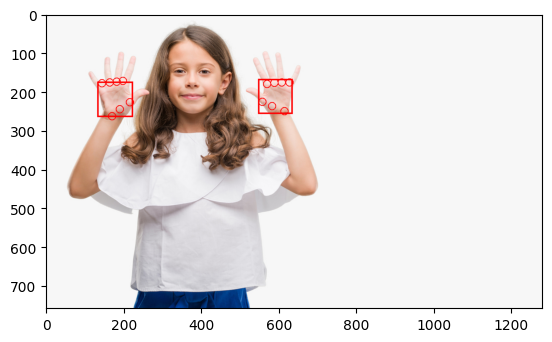

In [8]:
# Typically, outputs are retrieved in the Float32 format and de-quantized by HailoRT.
# However, if you need to extract outputs as INT8 or INT16, you can specify the layer name here.

layer_name_u8 = []  # Layers that output float32 format tensors
layer_name_u16 = []  # Layers that output uint16 format tensors

# https://www.istockphoto.com/en/photo/brunette-hispanic-girl-showing-and-pointing-up-with-fingers-number-ten-while-smiling-gm1042593516-279105620
input_image = "./iStock-1042593516.jpg"

frame = Image.open(input_image)
    
# Run inference from image
outputs, _, scale1, pad1 = inference_with_single_image(f"../hefs/{model_name}.hef", layer_name_u8, layer_name_u16, frame)

# Post process and draw the results if palm is detected within the image
if len(outputs) != 0:
    filtered_detections = postprocess(outputs, anchor_options, model_configs)
    image_output = draw_detections(frame, filtered_detections, scale1[0], pad1, model_configs)

    plt.imshow(image_output)

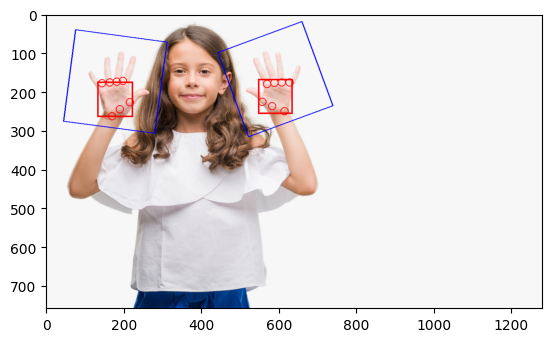

In [9]:
# Draw ROI
if len(outputs) != 0:
    image_roi = draw_roi(frame, filtered_detections, model_configs)
    plt.imshow(image_roi)